# Modelo de Default (UCI Credit Card) + Ação para Minimizar Provisionamento

**Objetivo:** criar um modelo para estimar a propensão de um cliente entrar em default no próximo mês e propor uma **política de ação** que minimize o **custo esperado de provisionamento** do banco.

**Regra do problema (importante):** a diferença entre o **Bill Amount** e o **Pay Amount do mês anterior** indica o **valor em aberto** (*outstanding*) de cada mês.

Este notebook foi estruturado em **seções** (como no seu código original) e cada etapa tem **explicação e justificativas**.


- Exploratory Data Analysis
- Feature Engineering
- Feature Selection
- Predictive Modeling
- Model Evaluation
- Financial Results


In [ ]:
# Make local src/ importable when running from notebooks/
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.features import add_features, drop_high_corr_features
from src.modeling import build_preprocessor, build_models, split_data, evaluate_model
from src.finance import run_scenarios


## STEP 0: Imports and Reading Data

**Objetivo desta seção:**
1) importar bibliotecas de forma organizada e reprodutível;  
2) carregar o dataset **via KaggleHub**

**Justificativas das escolhas:**
- `Pipeline/ColumnTransformer` (sklearn): evita vazamento, padroniza o pré-processamento e facilita auditoria.
- `RANDOM_STATE`: reprodutibilidade.
- Métricas e calibração serão tratadas em seções posteriores (para manter separação de responsabilidades).


Organizei o notebook com pipeline para garantir consistência e evitar leakage. E fixei random_state para reprodutibilidade.

In [34]:
# =========================================================
# STEP 0: Imports and Reading Data
# =========================================================

# Bibliotecas base
import numpy as np
import pandas as pd

# Visualização (EDA)
import matplotlib.pyplot as plt

# Modelagem (scikit-learn)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

# Avaliação
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    brier_score_loss
)

# Calibração
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Reprodutibilidade
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configurações úteis de exibição
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")



### Leitura do dataset via KaggleHub

Uso KaggleHub para evitar path local e facilitar execução reprodutíve


In [35]:
# =========================================================
# STEP 0: Reading Data (KaggleHub)
# =========================================================
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load (tente primeiro este)
file_path = "UCI_Credit_Card.csv"

# Load the latest version
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "uciml/default-of-credit-card-clients-dataset",
    file_path,
)

print("First 5 records:")
display(df.head())
print("Shape:", df.shape)


/tmp/ipython-input-1249339392.py:14: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
First 5 records:


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,"20,000.000",2,2,1,24,2,2,-1,-1,-2,-2,"3,913.000","3,102.000",689.000,0.000,0.000,0.000,0.000,689.000,0.000,0.000,0.000,0.000,1
1,2,"120,000.000",2,2,2,26,-1,2,0,0,0,2,"2,682.000","1,725.000","2,682.000","3,272.000","3,455.000","3,261.000",0.000,"1,000.000","1,000.000","1,000.000",0.000,"2,000.000",1
2,3,"90,000.000",2,2,2,34,0,0,0,0,0,0,"29,239.000","14,027.000","13,559.000","14,331.000","14,948.000","15,549.000","1,518.000","1,500.000","1,000.000","1,000.000","1,000.000","5,000.000",0
3,4,"50,000.000",2,2,1,37,0,0,0,0,0,0,"46,990.000","48,233.000","49,291.000","28,314.000","28,959.000","29,547.000","2,000.000","2,019.000","1,200.000","1,100.000","1,069.000","1,000.000",0
4,5,"50,000.000",1,2,1,57,-1,0,-1,0,0,0,"8,617.000","5,670.000","35,835.000","20,940.000","19,146.000","19,131.000","2,000.000","36,681.000","10,000.000","9,000.000",689.000,679.000,0


Shape: (30000, 25)


## STEP 1: Data Understanding

Aqui eu entendo o dataset, confirmo target e garanto que colunas identificadoras não virem feature.


**Objetivo desta seção:**
- visualizar `head()` e `tail()`
- checar `shape`, `dtypes`, `describe()`
- identificar possíveis problemas (nulos, tipos errados, categorias codificadas)

**Por que isso importa em risco de crédito?**
- O target pode estar desbalanceado
- Colunas numéricas podem representar **categorias** (ex.: `SEX`, `EDUCATION`, `MARRIAGE`)
- `PAY_0` é o status do mês mais recente e costuma ser muito preditivo, mas precisa ser tratado corretamente.


In [36]:
# =========================================================
# STEP 1: Data Understanding
# =========================================================

# Padronização de nomes (boa prática para reduzir ambiguidade):
# - PAY_0 -> PAY_1 (para manter sequência PAY_1..PAY_6)
# - default.payment.next.month -> DEFAULT (target)
df = df.rename(columns={
    "PAY_0": "PAY_1",
    "default.payment.next.month": "DEFAULT"
})

# View the first and last 5 rows
display(df.head())
display(df.tail())

# Dataframe shape
print("Temos:", df.shape[0],"linhas e ",df.shape[1],"colunas")

# dtypes
display(df.dtypes)

# describe (numérico)
display(df.describe().T)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,"20,000.000",2,2,1,24,2,2,-1,-1,-2,-2,"3,913.000","3,102.000",689.000,0.000,0.000,0.000,0.000,689.000,0.000,0.000,0.000,0.000,1
1,2,"120,000.000",2,2,2,26,-1,2,0,0,0,2,"2,682.000","1,725.000","2,682.000","3,272.000","3,455.000","3,261.000",0.000,"1,000.000","1,000.000","1,000.000",0.000,"2,000.000",1
2,3,"90,000.000",2,2,2,34,0,0,0,0,0,0,"29,239.000","14,027.000","13,559.000","14,331.000","14,948.000","15,549.000","1,518.000","1,500.000","1,000.000","1,000.000","1,000.000","5,000.000",0
3,4,"50,000.000",2,2,1,37,0,0,0,0,0,0,"46,990.000","48,233.000","49,291.000","28,314.000","28,959.000","29,547.000","2,000.000","2,019.000","1,200.000","1,100.000","1,069.000","1,000.000",0
4,5,"50,000.000",1,2,1,57,-1,0,-1,0,0,0,"8,617.000","5,670.000","35,835.000","20,940.000","19,146.000","19,131.000","2,000.000","36,681.000","10,000.000","9,000.000",689.000,679.000,0


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
29995,29996,"220,000.000",1,3,1,39,0,0,0,0,0,0,"188,948.000","192,815.000","208,365.000","88,004.000","31,237.000","15,980.000","8,500.000","20,000.000","5,003.000","3,047.000","5,000.000","1,000.000",0
29996,29997,"150,000.000",1,3,2,43,-1,-1,-1,-1,0,0,"1,683.000","1,828.000","3,502.000","8,979.000","5,190.000",0.000,"1,837.000","3,526.000","8,998.000",129.000,0.000,0.000,0
29997,29998,"30,000.000",1,2,2,37,4,3,2,-1,0,0,"3,565.000","3,356.000","2,758.000","20,878.000","20,582.000","19,357.000",0.000,0.000,"22,000.000","4,200.000","2,000.000","3,100.000",1
29998,29999,"80,000.000",1,3,1,41,1,-1,0,0,0,-1,"-1,645.000","78,379.000","76,304.000","52,774.000","11,855.000","48,944.000","85,900.000","3,409.000","1,178.000","1,926.000","52,964.000","1,804.000",1
29999,30000,"50,000.000",1,2,1,46,0,0,0,0,0,0,"47,929.000","48,905.000","49,764.000","36,535.000","32,428.000","15,313.000","2,078.000","1,800.000","1,430.000","1,000.000","1,000.000","1,000.000",1


Temos: 30000 linhas e  25 colunas


,0
ID,int64
LIMIT_BAL,float64
SEX,int64
EDUCATION,int64
MARRIAGE,int64
AGE,int64
PAY_1,int64
PAY_2,int64
PAY_3,int64
PAY_4,int64


,count,mean,std,min,25%,50%,75%,max
ID,"30,000.000","15,000.500","8,660.398",1.000,"7,500.750","15,000.500","22,500.250","30,000.000"
LIMIT_BAL,"30,000.000","167,484.323","129,747.662","10,000.000","50,000.000","140,000.000","240,000.000","1,000,000.000"
SEX,"30,000.000",1.604,0.489,1.000,1.000,2.000,2.000,2.000
EDUCATION,"30,000.000",1.853,0.790,0.000,1.000,2.000,2.000,6.000
MARRIAGE,"30,000.000",1.552,0.522,0.000,1.000,2.000,2.000,3.000
AGE,"30,000.000",35.486,9.218,21.000,28.000,34.000,41.000,79.000
PAY_1,"30,000.000",-0.017,1.124,-2.000,-1.000,0.000,0.000,8.000
PAY_2,"30,000.000",-0.134,1.197,-2.000,-1.000,0.000,0.000,8.000
PAY_3,"30,000.000",-0.166,1.197,-2.000,-1.000,0.000,0.000,8.000
PAY_4,"30,000.000",-0.221,1.169,-2.000,-1.000,0.000,0.000,8.000


### Verifocação de qualidade

**Justificativas:**
Sem isto, o modelo pode quebrar ou aprender padrões errados por défice de dados.


In [37]:
# Quantos valores nulos temos?
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls.head(20))

# Distribuição do target
display(df["DEFAULT"].value_counts())
display(df["DEFAULT"].value_counts(normalize=True).rename("proporção"))

# Checagem rápida de valores das colunas categóricas codificadas
for c in ["SEX", "EDUCATION", "MARRIAGE"]:
    print(f"\n{c} - valores:")
    display(df[c].value_counts(dropna=False).head(20))


,0
ID,0
LIMIT_BAL,0
SEX,0
EDUCATION,0
MARRIAGE,0
AGE,0
PAY_1,0
PAY_2,0
PAY_3,0
PAY_4,0


,count
DEFAULT,
0,23364
1,6636


,proporção
DEFAULT,
0,0.779
1,0.221



SEX - valores:


,count
SEX,
2,18112
1,11888



EDUCATION - valores:


,count
EDUCATION,
2,14030
1,10585
3,4917
5,280
4,123
6,51
0,14



MARRIAGE - valores:


,count
MARRIAGE,
2,15964
1,13659
3,323
0,54


### EDA visual

Esta EDA serve-me para entender possível desbalanceamento e sugerir features com sinal

- `LIMIT_BAL` costuma ser assimétrico, pela própria natureza do problema
- `AGE` pode ter skewness e concentrações em alguns intervalos


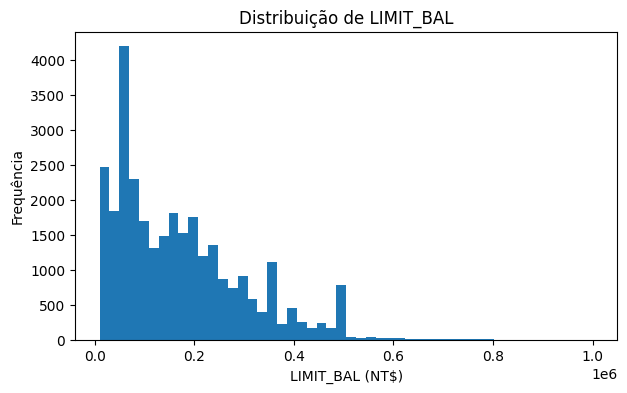

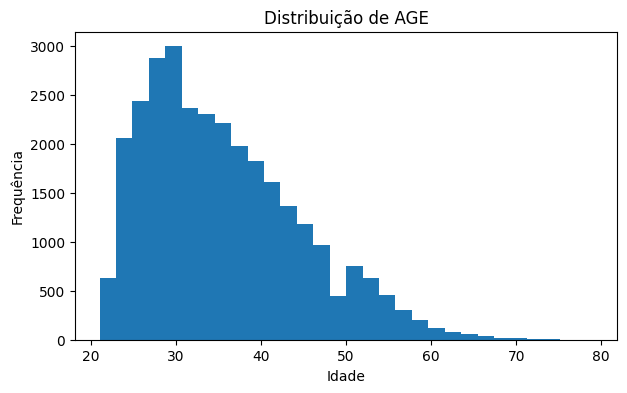

In [38]:
plt.figure(figsize=(7,4))
plt.hist(df["LIMIT_BAL"], bins=50)
plt.title("Distribuição de LIMIT_BAL")
plt.xlabel("LIMIT_BAL (NT$)")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(df["AGE"], bins=30)
plt.title("Distribuição de AGE")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()


Temos uma right-skewness para ambas as features. Algo que já era de esperar, dada a natureza do problema.

## STEP 2: Exploratory Data Analysis (EDA)

**Objetivo:** explorar relações simples com o target e checar sinais de separação. Eu usei estaa para orientar feuture engineering e selection


In [39]:
# =========================================================
# STEP 2: Exploratory Data Analysis (EDA)
# =========================================================

# Médias por classe (exemplo em algumas colunas-chave)
cols_check = ["LIMIT_BAL", "AGE", "BILL_AMT1", "PAY_AMT1", "PAY_1", "PAY_2", "PAY_3"]
eda_summary = df.groupby("DEFAULT")[cols_check].mean().T
display(eda_summary)

# Correlação rápida (numérica) para detectar redundância/colinearidade
corr = df.select_dtypes(include=[np.number]).corr()
# Mostrar correlação do target com principais features (em módulo)
target_corr = corr["DEFAULT"].drop("DEFAULT").abs().sort_values(ascending=False).head(15)
display(target_corr.rename("abs_corr_with_DEFAULT"))


DEFAULT,0,1
LIMIT_BAL,"178,099.726","130,109.656"
AGE,35.417,35.726
BILL_AMT1,"51,994.227","48,509.162"
PAY_AMT1,"6,307.337","3,397.044"
PAY_1,-0.211,0.668
PAY_2,-0.302,0.458
PAY_3,-0.316,0.362


,abs_corr_with_DEFAULT
PAY_1,0.325
PAY_2,0.264
PAY_3,0.235
PAY_4,0.217
PAY_5,0.204
PAY_6,0.187
LIMIT_BAL,0.154
PAY_AMT1,0.073
PAY_AMT2,0.059
PAY_AMT4,0.057


# **STEP 3: Feature Engineering**

Cálculo do valor em aberto (OUTSTANDING)

O enunciado sugere considerar que:
> a diferença entre o Bill Amount do mês e o Pay Amount do mês anterior representa o valor em aberto.

Alinhamento usado:
- `OUTSTANDING_1 = BILL_AMT1 - PAY_AMT2`
- `OUTSTANDING_2 = BILL_AMT2 - PAY_AMT3`
- ...
- `OUTSTANDING_5 = BILL_AMT5 - PAY_AMT6`

Bão calculo OUTSTANDING_6 porque não existe PAY_AMT7

**Detalhe importante:** aplicaremos `clip(lower=0)` para evitar “aberto negativo”.


Transformo a regra do enunciado em variáveis de pendência e agrego comportamento temporal (seja esta uma tendência ou atraso). OUTSTANDING_SUM vira-se um provisionamento virtual.

In [40]:
# =========================================================
# STEP 3: Feature Engineering
# =========================================================

def add_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # Outstanding conforme regra: BILL(mês) - PAY(mês anterior)
    # Meses no dataset (BILL_AMT1..6) = Sep..Apr e PAY_AMT1..6 = Sep..Apr
    # Para "mês anterior", alinhamos: BILL_AMT1 com PAY_AMT2, ..., BILL_AMT5 com PAY_AMT6
    # Calculo OUTSTANDING_1..5, não calculo o 6, porque não existe PAY_AMT7 no dataset


    for m in range(1, 6):
        df[f"OUTSTANDING_{m}"] = (df[f"BILL_AMT{m}"] - df[f"PAY_AMT{m+1}"]).clip(lower=0)

    out_cols = [f"OUTSTANDING_{m}" for m in range(1, 6)]
    df["OUTSTANDING_SUM"] = df[out_cols].sum(axis=1) #provisionamento virtual
    df["OUTSTANDING_MAX"] = df[out_cols].max(axis=1)
    df["OUTSTANDING_MEAN"] = df[out_cols].mean(axis=1)
    df["OUTSTANDING_POS_MONTHS"] = (df[out_cols] > 0).sum(axis=1)

    # Razões PAY/BILL (para evitar divisão por zero, acrescentei 1 no denominador)
    for m in range(1, 7):
        denom = df[f"BILL_AMT{m}"].abs() + 1.0
        df[f"PAY_RATIO_{m}"] = df[f"PAY_AMT{m}"] / denom #pagamento relativo à fatura

    # Tendências simples
    df["BILL_TREND_1_6"] = df["BILL_AMT1"] - df["BILL_AMT6"]
    df["PAY_TREND_1_6"]  = df["PAY_AMT1"] - df["PAY_AMT6"]

    # Dinâmica de atraso (PAY_1..PAY_6): máximo e contagem de meses com atraso (>0)
    pay_cols = [f"PAY_{i}" for i in range(1, 7)]
    df["PAY_MAX"] = df[pay_cols].max(axis=1)
    df["PAY_MIN"] = df[pay_cols].min(axis=1)
    df["PAY_LATE_MONTHS"] = (df[pay_cols] > 0).sum(axis=1)

    return df

df_fe = add_features(df)
display(df_fe.filter(regex="^OUTSTANDING_").head())
print("Novas colunas criadas:", len(df_fe.columns) - len(df.columns))


,OUTSTANDING_1,OUTSTANDING_2,OUTSTANDING_3,OUTSTANDING_4,OUTSTANDING_5,OUTSTANDING_SUM,OUTSTANDING_MAX,OUTSTANDING_MEAN,OUTSTANDING_POS_MONTHS
0,"3,224.000","3,102.000",689.000,0.000,0.000,"7,015.000","3,224.000","1,403.000",3
1,"1,682.000",725.000,"1,682.000","3,272.000","1,455.000","8,816.000","3,272.000","1,763.200",5
2,"27,739.000","13,027.000","12,559.000","13,331.000","9,948.000","76,604.000","27,739.000","15,320.800",5
3,"44,971.000","47,033.000","48,191.000","27,245.000","27,959.000","195,399.000","48,191.000","39,079.800",5
4,0.000,0.000,"26,835.000","20,251.000","18,467.000","65,553.000","26,835.000","13,110.600",3


Novas colunas criadas: 20


## STEP 4: Feature Selection

**Por que fazer (mesmo que leve):**
- Em dados financeiros, muitas colunas são altamente correlacionadas (ex.: `BILL_AMT1..6`).
- Seleção simples ajuda interpretabilidade e reduz risco de overfitting.

**Estratégia aqui:**
- Para baseline, usaremos regularização (Logistic Regression) que já ajuda.
- Como extra, mostramos como remover features com correlação muito alta.

Observação: em produção, faríamos seleção via validação cruzada e/ou importância por permutação.


In [41]:
# =========================================================
# STEP 4: Feature Selection
# =========================================================

# Exemplo: remover colunas extremamente correlacionadas (apenas numéricas)
def drop_high_corr_features(df_in: pd.DataFrame, threshold: float = 0.98, target_col: str = "DEFAULT") -> pd.DataFrame:
    df_num = df_in.select_dtypes(include=[np.number]).copy()
    if target_col in df_num.columns:
        df_num = df_num.drop(columns=[target_col])

    corr = df_num.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    return to_drop

high_corr_to_drop = drop_high_corr_features(df_fe, threshold=0.98, target_col="DEFAULT")
print("Sugestão de features para remover por alta correlação:", high_corr_to_drop[:20], " ... total:", len(high_corr_to_drop))


Sugestão de features para remover por alta correlação: ['OUTSTANDING_1', 'OUTSTANDING_2', 'OUTSTANDING_3', 'OUTSTANDING_4', 'OUTSTANDING_5', 'OUTSTANDING_MEAN']  ... total: 6


## STEP 5: Predictive Modeling

### Escolhas de modelos e justificativas
1) **Regressão Logística (baseline)**
- Forte em risco de crédito, interpretável, robusta e ótima para explicar decisões.
- Com `class_weight='balanced'` lidamos melhor com desbalanceamento.

2) **Gradient Boosting (HistGradientBoosting)**
- Captura não-linearidades/interações. Em datasets tabulares, geralmente eleva performance.

Estas soluções são baseadas num trabalho de risco hidrológico usando iA, além de notebook do kaggle.

### Por que usar Pipeline?
O pipeline garante que preprocessamento e modelo sejam treinados juntos sem vazamento. LR é baseline e HGB captura interações

In [46]:
# =========================================================
# STEP 5: Predictive Modeling
# =========================================================

# Definindo X, y
X = df_fe.drop(columns=["DEFAULT", "ID"])
y = df_fe["DEFAULT"].astype(int) #Isto é o que pretendo predizer

# Colunas categóricas codificadas
cat_cols = ["SEX", "EDUCATION", "MARRIAGE"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Split estratificado (mantém proporção do target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Pré-processamento
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

# Modelos
pipe_logreg = Pipeline(steps=[
    ("pre", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

pipe_hgb = Pipeline(steps=[
    ("pre", preprocess),
    ("model", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

print("Treino/Teste:", X_train.shape, X_test.shape)


Treino/Teste: (24000, 43) (6000, 43)


## STEP 6: Model Evaluation

### Métricas escolhidas e justificativas
- **ROC-AUC**: mede capacidade de ranking global (boa para comparar modelos).
- **PR-AUC**: mais informativa quando a classe positiva (default) é minoritária.
- **Matriz de confusão**: ajuda a entender o trade-off (FP vs FN) — importante para política de ação.

➡️ Importante: para decisão de negócio, **threshold 0.5 raramente é o melhor**. Na seção de resultados financeiros, adotaremos um critério baseado em custo/provisionamento.


In [47]:
# =========================================================
# STEP 6: Model Evaluation
# =========================================================

def avaliar(modelo, X_train, y_train, X_test, y_test, nome="modelo"):
    modelo.fit(X_train, y_train)
    proba = modelo.predict_proba(X_test)[:, 1]

    roc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)

    print(f"=== {nome} ===")
    print("ROC-AUC:", roc)
    print("PR-AUC :", pr)

    # threshold padrão (apenas diagnóstico inicial)
    thr = 0.5
    pred = (proba >= thr).astype(int)
    print("Confusion Matrix w/ (thr=0.5):")
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, digits=3))

    return proba

proba_lr  = avaliar(pipe_logreg,  X_train, y_train, X_test, y_test, nome="Logistic Regression")
proba_hgb = avaliar(pipe_hgb, X_train, y_train, X_test, y_test, nome="HistGradientBoosting")


=== Logistic Regression (baseline) ===
ROC-AUC: 0.7500694638071391
PR-AUC : 0.5073599846104607
Confusion Matrix w/ (thr=0.5):
[[3643 1030]
 [ 524  803]]
              precision    recall  f1-score   support

           0      0.874     0.780     0.824      4673
           1      0.438     0.605     0.508      1327

    accuracy                          0.741      6000
   macro avg      0.656     0.692     0.666      6000
weighted avg      0.778     0.741     0.754      6000

=== HistGradientBoosting ===
ROC-AUC: 0.7760413483412786
PR-AUC : 0.5477105232871655
Confusion Matrix w/ (thr=0.5):
[[4422  251]
 [ 844  483]]
              precision    recall  f1-score   support

           0      0.840     0.946     0.890      4673
           1      0.658     0.364     0.469      1327

    accuracy                          0.818      6000
   macro avg      0.749     0.655     0.679      6000
weighted avg      0.800     0.818     0.797      6000



## STEP 7: Financial Results (Ação para Minimizar Provisionamento)

Esta seção conecta o modelo ao objetivo.

### Premissas e hipóteses (explícitas)
- **Exposure**: usamos `OUTSTANDING_SUM` como valor em aberto esperado "virtual".
- **Sem ação**: custo esperado = \(\sum p_i \cdot Exposure_i\).
- **Ação**: contato/renegociação/alerta com custo `C_action`.
- **Efeito da ação**: reduz a probabilidade de default em uma fração `r` (hipótese).

### Regra de decisão (custo-benefício)
Agir se o benefício esperado superar o custo:
\[
(p_i - p_i) \cdot Exposure_i > C_{action}
\Rightarrow r\cdot p_i\cdot Exposure_i > C_{action}
\]

**Ponto-chave:** o threshold não é fixo (0.5). Ele depende do exposure do cliente.


In [44]:
# =========================================================
# STEP 7: Financial Results
# =========================================================

def simular_politica(proba, X_features, r=0.15, c_action=50.0, exposure_col="OUTSTANDING_SUM"):
    """Simula custo esperado com e sem ação, sob hipóteses (r, C_action)."""
    exposure = X_features[exposure_col].values.astype(float)

    baseline_cost = np.sum(proba * exposure)

    # Decisão ótima simples: agir se r*p*Exposure > C_action
    act = (r * proba * exposure) > c_action

    proba_after = proba.copy()
    proba_after[act] = proba_after[act] * (1 - r)

    new_cost = np.sum(proba_after * exposure) + act.sum() * c_action

    return {
        "baseline_expected_cost": baseline_cost,
        "new_expected_cost": new_cost,
        "savings_abs": baseline_cost - new_cost,
        "savings_pct": (baseline_cost - new_cost) / baseline_cost if baseline_cost > 0 else np.nan,
        "n_targeted": int(act.sum()),
        "target_rate": float(act.mean())
    }

# Para política financeira, usamos a probabilidade direta do melhor modelo que é o ensemble method
proba_use = proba_hgb
X_test_features = X_test.copy()

scenarios = [
    {"r": 0.10, "c_action": 30.0},
    {"r": 0.15, "c_action": 50.0},
    {"r": 0.20, "c_action": 80.0},
]

rows = []
for sc in scenarios:
    res = simular_politica(proba_use, X_test_features, r=sc["r"], c_action=sc["c_action"])
    rows.append({**sc, **res})

results_df = pd.DataFrame(rows)
display(results_df)


,r,c_action,baseline_expected_cost,new_expected_cost,savings_abs,savings_pct,n_targeted,target_rate
0,0.100,30.000,"283,729,587.436","255,523,026.402","28,206,561.034",0.099,5378,0.896
1,0.150,50.000,"283,729,587.436","241,446,548.788","42,283,038.648",0.149,5343,0.890
2,0.200,80.000,"283,729,587.436","227,422,935.989","56,306,651.448",0.198,5270,0.878


### Visualização do trade-off

Se a ação fica mais cara ou menos efetiva, a economia muda e o número de clientes acionados também.

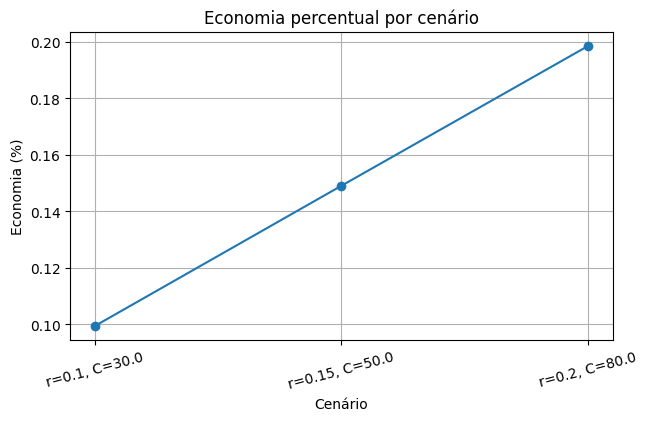

In [45]:
plt.figure(figsize=(7,4))
plt.plot(range(len(results_df)), results_df["savings_pct"], marker="o")
plt.title("Economia percentual por cenário")
plt.xlabel("Cenário")
plt.ylabel("Economia (%)")
plt.xticks(
    range(len(results_df)),
    [f"r={r}, C={c}" for r, c in zip(results_df["r"], results_df["c_action"])],
    rotation=15
)
plt.grid(True)
plt.show()
